# **M1 Exam Submission part 2**

## **Table of Contents**

#### I. Import Libraries and Data
#### II. Data Preparation
#### III. Model Development
#### IV. Model Evaluation

### Funding Duration Prediction:
### Target: funding_duration_days (Time to Secure Loan)

### Problem Statement:

The objective is to predict how long it will take for a loan request to be fully funded, based on factors such as the borrower's country, sector, activity type, loan amount, and number of lenders. By understanding these relationships, the model can provide insights into which factors lead to faster or slower funding times.
Type of Model:
The model will use regression, as the target variable (funding_duration_days) represents a continuous numerical value. The goal is to predict the number of days required to secure full funding for a loan based on the given features.
### Objective:
This model aims to assist lending platforms and financial institutions in forecasting how long a loan will take to be fully funded after a request is made. This can help in optimizing loan approval strategies, better managing borrower expectations, and allocating resources efficiently to improve funding success rates.

In [2]:
# install all requried libraries
!pip install -r https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/requirements.txt?token=GHSAT0AAAAAACW5CC7AEACQJUGM4YNOK6XSZX5FAIQ

In [3]:
#import libraries
import pandas as pd             # for data manipulation
import numpy as np              # for mathematical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for data visualization
from scipy.stats import zscore  # for standardizing data & removing outliers
import geopandas as gpd # for   # !!! check usecase of geopandas...
import altair as alt            # for interactive visualization
from vega_datasets import data  # for data visualization

#additional libraries for importing data from github
import requests                 # used for importing data
import io                       # used for converting response content to a file-like object for pandas

# library used for gender mapping - section 4
import re

In [14]:
# definition of url-paths for datasets
url1 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_0.csv?token=GHSAT0AAAAAACW5CC7BUKRXCRU7APTH5Q4EZX5FNYA'
url2 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_1.csv?token=GHSAT0AAAAAACW5CC7B5N3TSECZ4BHAIWIOZX5FN6A'
url3 = 'https://raw.githubusercontent.com/JAdamHub/M1-Exam-Submission/refs/heads/main/kiva_loans_part_2.csv?token=GHSAT0AAAAAACW5CC7AP4TAV3AH63VJT4RAZX5FN6Q'

# loading the urls into requests to download data
response1 = requests.get(url1)
response2 = requests.get(url2)
response3 = requests.get(url3)

# convert the response content to a file-like object for pandas using io.StringIO
# the advantage of StringIO is that it allows us to import the data without having to save it as a file for pandas
data_part1 = pd.read_csv(io.StringIO(response1.text))
data_part2 = pd.read_csv(io.StringIO(response2.text))
data_part3 = pd.read_csv(io.StringIO(response3.text))


In [ ]:
# Check the initial state
print("Initial state:")
print("Missing values in funded_time:", data['funded_time'].isna().sum())
print("Missing values in disbursed_time:", data['disbursed_time'].isna().sum())
print("Data types:")
print(data[['funded_time', 'disbursed_time']].dtypes)
print("\nSample of initial data:")
print(data[['funded_time', 'disbursed_time']].head())

# Apply the changes
data['funded_time'] = data['funded_time'].where(data['funded_time'].notna(), None)
data['disbursed_time'] = data['disbursed_time'].where(data['disbursed_time'].notna(), None)

# Check the final state
print("\nAfter changes:")
print("Missing values in funded_time:", data['funded_time'].isna().sum())
print("Missing values in disbursed_time:", data['disbursed_time'].isna().sum())
print("Data types:")
print(data[['funded_time', 'disbursed_time']].dtypes)
print("\nSample of modified data:")
print(data[['funded_time', 'disbursed_time']].head())

Initial state:
Missing values in funded_time: 48331
Missing values in disbursed_time: 2396
Data types:
funded_time       datetime64[ns, UTC]
disbursed_time    datetime64[ns, UTC]
dtype: object

Sample of initial data:
                funded_time            disbursed_time
0 2014-01-02 10:06:32+00:00 2013-12-17 08:00:00+00:00
1 2014-01-02 09:17:23+00:00 2013-12-17 08:00:00+00:00
2 2014-01-01 16:01:36+00:00 2013-12-17 08:00:00+00:00
3 2014-01-01 13:00:00+00:00 2013-12-24 08:00:00+00:00
4 2014-01-01 19:18:51+00:00 2013-12-17 08:00:00+00:00

After changes:
Missing values in funded_time: 48331
Missing values in disbursed_time: 2396
Data types:
funded_time       datetime64[ns, UTC]
disbursed_time    datetime64[ns, UTC]
dtype: object

Sample of modified data:
                funded_time            disbursed_time
0 2014-01-02 10:06:32+00:00 2013-12-17 08:00:00+00:00
1 2014-01-02 09:17:23+00:00 2013-12-17 08:00:00+00:00
2 2014-01-01 16:01:36+00:00 2013-12-17 08:00:00+00:00
3 2014-01-01 13:00:00+

In [4]:
!wget -nc "https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_0.csv.zip"
!wget -nc "https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_1.csv.zip"
!wget -nc "https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_2.csv.zip"

# Unzip to csv
!unzip -o kiva_loans_part_0.csv.zip
!unzip -o kiva_loans_part_1.csv.zip
!unzip -o kiva_loans_part_2.csv.zip

# Loading datasets
data_part1 = pd.read_csv("kiva_loans_part_0.csv")
data_part2 = pd.read_csv("kiva_loans_part_1.csv")
data_part3 = pd.read_csv("kiva_loans_part_2.csv")

/bin/bash: wget: command not found
/bin/bash: wget: command not found
/bin/bash: wget: command not found
unzip:  cannot find or open kiva_loans_part_0.csv.zip, kiva_loans_part_0.csv.zip.zip or kiva_loans_part_0.csv.zip.ZIP.
unzip:  cannot find or open kiva_loans_part_1.csv.zip, kiva_loans_part_1.csv.zip.zip or kiva_loans_part_1.csv.zip.ZIP.
unzip:  cannot find or open kiva_loans_part_2.csv.zip, kiva_loans_part_2.csv.zip.zip or kiva_loans_part_2.csv.zip.ZIP.


FileNotFoundError: [Errno 2] No such file or directory: 'kiva_loans_part_0.csv'

In [50]:
# We can see, that the imported loan dataset consists of 3 parts. We will like to combine these to one big dataset
data = pd.concat([data_part1, data_part2, data_part3])

In [51]:
data = data.drop(['tags', 'use', 'currency', 'country_code'], axis=1)

In [52]:
#Storing length of rows for comparing, >> before dropna.. <<
data_rows = len(data)

#Dropping missing values
data.dropna(inplace=True)

#Storing the now cleaned dataset
cleaned_rows = len(data)

#Check..
drops = data_rows - cleaned_rows

print(f"Number of dropped rows: {drops}")
print(f'In percentage {(drops / data_rows) * 100:.2f} % of the data was removed')

Number of dropped rows: 97078
In percentage 14.46 % of the data was removed


In [53]:
# Loans never funded
data['funded_time'] = data['funded_time'].where(data['funded_time'].notna(), None)

In [54]:
# Calculate Z-scores
z_scores = zscore(data['loan_amount'])

# Get boolean array indicating the presence of outliers
# Using 2 & -2 z_scores to get 95% of data within 2 standard deviations
data['outlier_loan_amount'] = (z_scores > 2) | (z_scores < -2)


#Removing outliers
data_clean = data[~data['outlier_loan_amount']]

# Check amount of outliers (if any?)
data['outlier_loan_amount'].sum()

np.int64(23129)

In [55]:
male = data_clean[data_clean['borrower_genders'] == 'male']
female = data_clean[data_clean['borrower_genders'] == 'female']
print ('Total Male loans',male.shape[0])
print ('Total Female loans',female.shape[0])

Total Male loans 101344
Total Female loans 374745


In [64]:
loans = data_clean

# Count the number of male and female borrowers
loans['male_borrowers'] = loans['borrower_genders'].apply(lambda x: len(re.findall(r'\bmale', x)))
loans['female_borrowers'] = loans['borrower_genders'].apply(lambda x: len(re.findall(r'\bfemale', x)))

# Calculate the total number of borrowers
loans['borrowers_count'] = loans['male_borrowers'] + loans['female_borrowers']

# Handle situations where 'borrowers_count' is 0 to avoid division by 0
loans['male_borrower_ratio'] = loans['male_borrowers'] / loans['borrowers_count'].replace(0, 1)

# Function to classify gender based on the ratio
def classify_genders(ratio):
    if ratio == 1:
        return 'male(s)'
    elif ratio == 0:
        return 'female(s)'
    else:
        return 'mixed gender group'

# Apply gender classification
loans['gender_class'] = loans['male_borrower_ratio'].apply(classify_genders)

# Print the result
print(loans[['borrower_genders', 'male_borrowers', 'female_borrowers', 'borrowers_count', 'male_borrower_ratio', 'gender_class']])

loans


/tmp/ipykernel_1678/596841677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['male_borrowers'] = loans['borrower_genders'].apply(lambda x: len(re.findall(r'\bmale', x)))
/tmp/ipykernel_1678/596841677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['female_borrowers'] = loans['borrower_genders'].apply(lambda x: len(re.findall(r'\bfemale', x)))
/tmp/ipykernel_1678/596841677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

       borrower_genders  male_borrowers  female_borrowers  borrowers_count  \
0                female               0                 1                1   
1        female, female               0                 2                2   
2                female               0                 1                1   
3                female               0                 1                1   
4                female               0                 1                1   
...                 ...             ...               ...              ...   
221157           female               0                 1                1   
221163           female               0                 1                1   
221164           female               0                 1                1   
221170           female               0                 1                1   
221186           female               0                 1                1   

        male_borrower_ratio gender_class  
0                   

,id,funded_amount,loan_amount,activity,sector,country,region,partner_id,posted_time,disbursed_time,...,lender_count,borrower_genders,repayment_interval,date,outlier_loan_amount,male_borrowers,female_borrowers,borrowers_count,male_borrower_ratio,gender_class
0,653051,300.0,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,...,12,female,irregular,2014-01-01,False,0,1,1,0.0,female(s)
1,653053,575.0,575.0,Rickshaw,Transportation,Pakistan,Lahore,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,...,14,"female, female",irregular,2014-01-01,False,0,2,2,0.0,female(s)
2,653068,150.0,150.0,Transportation,Transportation,India,Maynaguri,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,...,6,female,bullet,2014-01-01,False,0,1,1,0.0,female(s)
3,653063,200.0,200.0,Embroidery,Arts,Pakistan,Lahore,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,...,8,female,irregular,2014-01-01,False,0,1,1,0.0,female(s)
4,653084,400.0,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,...,16,female,monthly,2014-01-01,False,0,1,1,0.0,female(s)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221157,1340272,75.0,75.0,Livestock,Agriculture,Mexico,Iztacalco,294.0,2017-07-21 23:00:01+00:00,2017-07-21 07:00:00+00:00,...,3,female,monthly,2017-07-21,False,0,1,1,0.0,female(s)
221163,1340253,25.0,25.0,Livestock,Agriculture,Paraguay,Concepción,58.0,2017-07-21 07:05:51+00:00,2017-07-21 07:00:00+00:00,...,1,female,monthly,2017-07-21,False,0,1,1,0.0,female(s)
221164,1340256,25.0,25.0,Livestock,Agriculture,Pakistan,Attock,245.0,2017-07-21 15:16:37+00:00,2017-07-21 07:00:00+00:00,...,1,female,monthly,2017-07-21,False,0,1,1,0.0,female(s)
221170,1340267,25.0,25.0,Livestock,Agriculture,Pakistan,Attock,245.0,2017-07-21 21:46:10+00:00,2017-07-21 07:00:00+00:00,...,1,female,monthly,2017-07-21,False,0,1,1,0.0,female(s)


In [67]:
# We would like to also include the time/duration between posted_time and funded_time - in other words: how long it takes to get a loan funded
# convert to pd.datetime
loans['posted_time'] = pd.to_datetime(loans['posted_time'])
loans['funded_time'] = pd.to_datetime(loans['funded_time'])

# calculate time between posted_time and funded_time
loans['funding_duration'] = loans['funded_time'] - loans['posted_time']

# the result in days instead
loans['funding_duration_days'] = (loans['funded_time'] - loans['posted_time']).dt.total_seconds() / (24 * 60 * 60)

# first rows to check
loans[['posted_time', 'funded_time', 'funding_duration', 'funding_duration_days']].head()

/tmp/ipykernel_1678/1345356496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['posted_time'] = pd.to_datetime(loans['posted_time'])
/tmp/ipykernel_1678/1345356496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans['funded_time'] = pd.to_datetime(loans['funded_time'])
/tmp/ipykernel_1678/1345356496.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,posted_time,funded_time,funding_duration,funding_duration_days
0,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,1 days 03:53:53,1.162419
1,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,1 days 02:26:15,1.101562
2,2014-01-01 09:58:07+00:00,2014-01-01 16:01:36+00:00,0 days 06:03:29,0.252419
3,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,0 days 04:56:49,0.206123
4,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,0 days 07:25:32,0.309398


## SML Preparation

In [56]:
# Libs needed for section 7 (some already imported)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

#  Model selection & Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score

# pipeline for the different models
from sklearn.pipeline import Pipeline

# decision Tree
from sklearn.tree import DecisionTreeRegressor

# tabular data explanation with LIME
import lime.lime_tabular  

# install shap & import
!pip install lime shap pdpbox -qqq

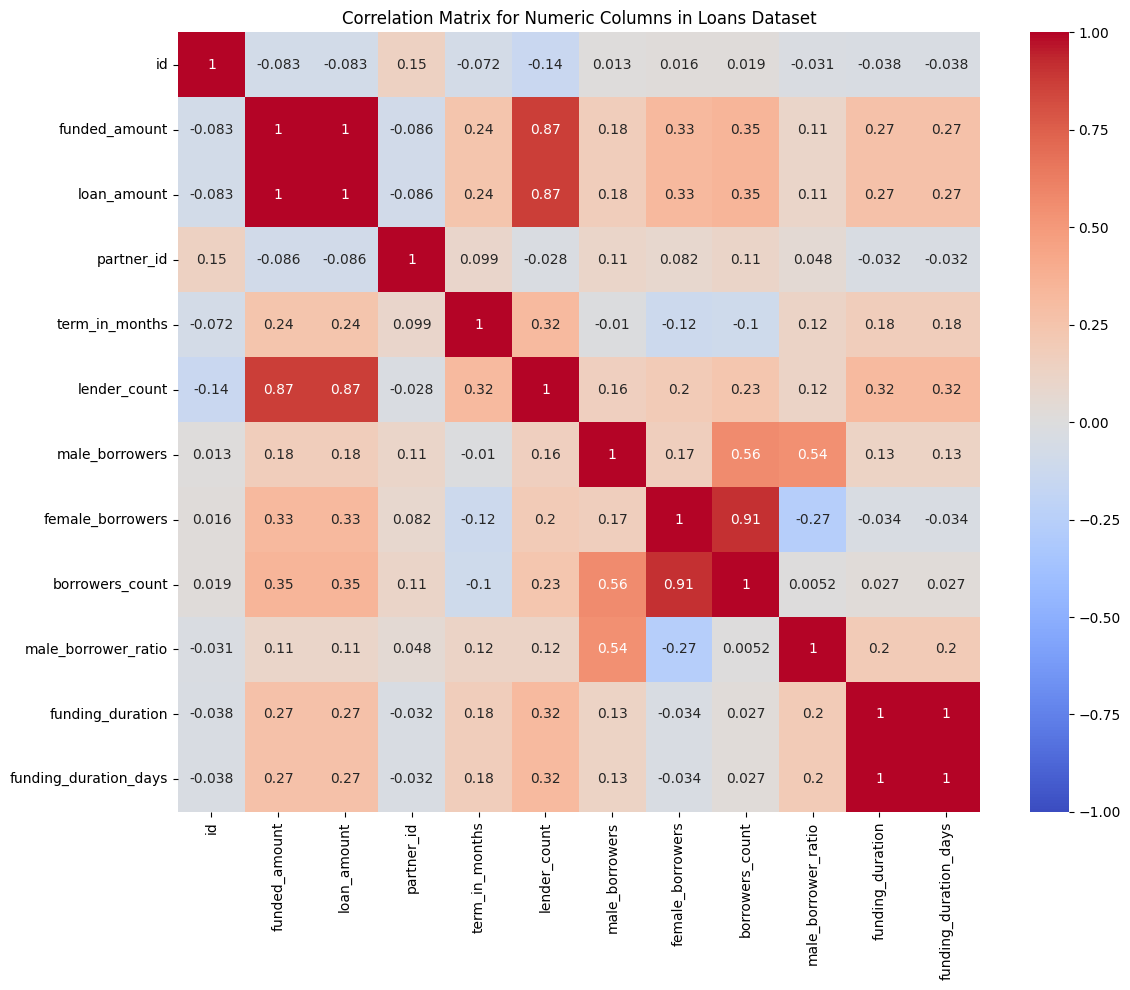

In [68]:
# it's a good idea to check the correlation matrix, to check if relevant columns may correlate to much with others
numeric_columns = loans.select_dtypes(include=[np.number]).columns

# Beregn korrelationsmatrix
corr_matrix = loans[numeric_columns].corr()

# Plot korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Numeric Columns in Loans Dataset')
plt.tight_layout()
plt.show()

In [59]:
data_clean.head()

,id,funded_amount,loan_amount,activity,sector,country,region,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,borrower_genders,repayment_interval,date,outlier_loan_amount
0,653051,300.0,300.0,Fruits & Vegetables,Food,Pakistan,Lahore,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,female,irregular,2014-01-01,False
1,653053,575.0,575.0,Rickshaw,Transportation,Pakistan,Lahore,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,"female, female",irregular,2014-01-01,False
2,653068,150.0,150.0,Transportation,Transportation,India,Maynaguri,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,female,bullet,2014-01-01,False
3,653063,200.0,200.0,Embroidery,Arts,Pakistan,Lahore,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,female,irregular,2014-01-01,False
4,653084,400.0,400.0,Milk Sales,Food,Pakistan,Abdul Hakeem,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,female,monthly,2014-01-01,False


In [69]:
#Filtering only the relevant columns for the model
relevant_columns = [
    'loan_amount',
    'activity',
    'sector',
    'country',
    'region',
    'posted_time',
    'funded_time',
    'borrowers_count',
    'gender_class',
    'funding_duration_days',
    'term_in_months',
]


In [1]:
loans_df = loans[relevant_columns]

NameError: name 'loans' is not defined